## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import glob, json
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
import os
from PIL import Image

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [ ]:
train_path='/content/drive/MyDrive/Colab_Notebooks/Field project/tumor_dataset/train/'
test_path="/content/drive/MyDrive/Colab_Notebooks/Field project/tumor_dataset/test/"
valid_path='/content/drive/MyDrive/Colab_Notebooks/Field project/tumor_dataset/valid/'

In [ ]:
train_data=[image for image in os.listdir(train_path)]
test_data=[image for image in os.listdir(test_path)]
valid_data=[image for image in os.listdir(valid_path)]

In [ ]:
len(train_data), len(test_data), len(valid_data)

(1514, 217, 431)

In [ ]:
train_annotation=glob.glob(os.path.join(train_path,"*.json"))
test_annotation=glob.glob(os.path.join(test_path,"*.json"))
valid_annotation=glob.glob(os.path.join(valid_path,"*.json"))


In [ ]:
valid_annotation

['/content/drive/MyDrive/Colab_Notebooks/Field project/tumor_dataset/valid/_annotations.coco.json']

In [ ]:
train_annotation[0]

'/content/drive/MyDrive/Colab_Notebooks/Field project/tumor_dataset/train/_annotations.coco.json'

In [ ]:
train_annotation=json.load(open(train_annotation[0]))
test_annotation=json.load(open(test_annotation[0]))
valid_annotation=json.load(open(valid_annotation[0]))

len(train_annotation), len(test_annotation), len(valid_annotation)

(5, 5, 5)

In [ ]:
len(train_annotation['images']), len(train_annotation['annotations'])

(1502, 1502)

In [ ]:
train_annotation['images'][0]

{'id': 0,
 'license': 1,
 'file_name': '2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg',
 'height': 640,
 'width': 640,
 'date_captured': '2023-08-19T04:37:54+00:00'}

In [ ]:
train_annotation['annotations'][0]

{'id': 0,
 'image_id': 0,
 'category_id': 1,
 'bbox': [145, 239, 168.75, 162.5],
 'area': 27421.875,
 'segmentation': [[313.75,
   238.75,
   145,
   238.75,
   145,
   401.25,
   313.75,
   401.25,
   313.75,
   238.75]],
 'iscrowd': 0}

* Mask annotations is given in JSON format.

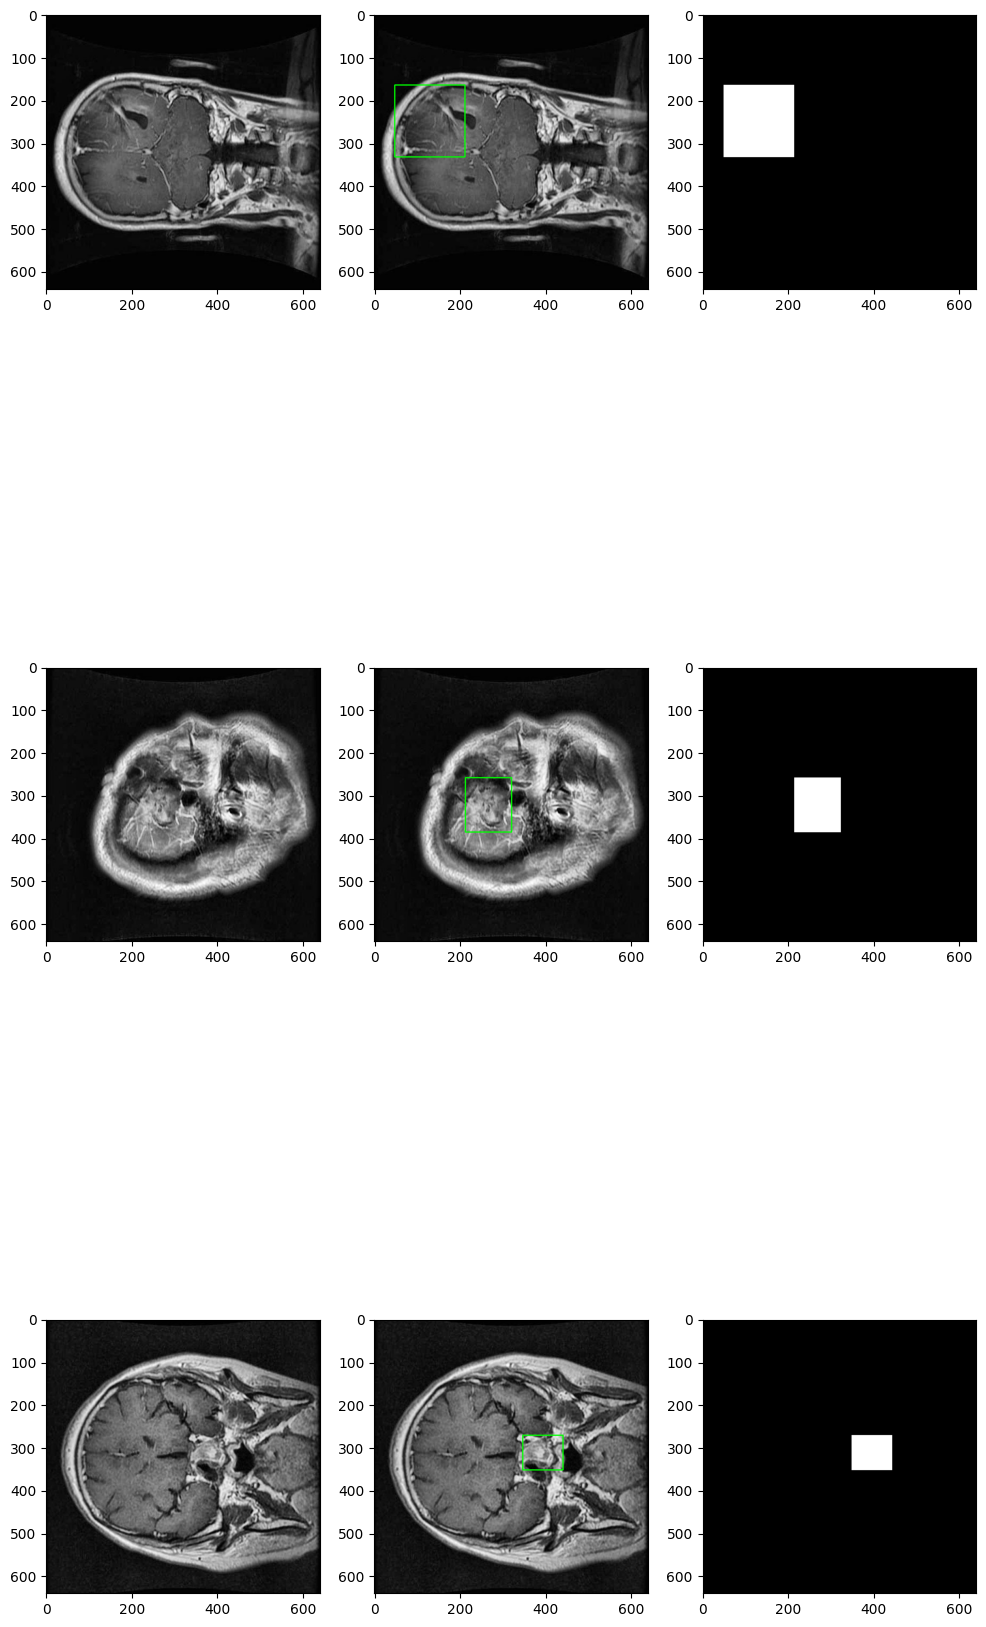

In [ ]:
import matplotlib.pyplot as plt

def visualize_random_images(n=3): # select n random images

    # use cv and plt to show these images
    indices = np.random.randint(0, len(train_annotation['images']), size=n)

    #Image and Annotation Retrieval:
    images =[train_annotation['images'][i] for i in indices ]
    annotations = [train_annotation['annotations'][i] for i in indices ]

    j=1
    plt.figure(figsize=(12, 4 * 2 * n))
    for img,ann in zip(images,annotations):

        plt.subplot(n,3,j)
        j+=1
        image = cv2.imread(train_path + img['file_name'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)

        # create masked images from annotations
        segmentation = ann['segmentation']
        segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2) #convert 1D into 2D

        cv2.polylines(image, [segmentation], isClosed=True, color=(0, 255, 0), thickness=2)  # Green color with thickness 2

        plt.subplot(n,3,j)
        plt.imshow(image)
        j+=1

        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillPoly(mask, [segmentation], color=1)
        plt.subplot(n,3,j)
        plt.imshow(mask,cmap='gray')
        j+=1

visualize_random_images()

## Create Mask of each images

In [ ]:
def _train_masks():
    print('train masks')
    mask_dir = '/content/drive/MyDrive/Colab_Notebooks/Field project/tumor_dataset/train_masks/'
    os.makedirs(mask_dir, exist_ok=True)
    totalImages = len(train_annotation['images'])
    done = 0
    for img,ann in zip(train_annotation['images'],train_annotation['annotations']):
        path = train_path + img['file_name']
        mask_path = mask_dir + img['file_name']
        # load image in open cv
        image = cv2.imread(path)
        segmentation = ann['segmentation']
        segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2)
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillPoly(mask, [segmentation], color=(255,255,255))
        cv2.imwrite(mask_path, mask)
        done+=1
        print(f"train  {done} / {totalImages} ")

def _test_masks():
    print('test masks')

    totalImages = len(test_annotation['images'])
    done = 0
    mask_dir = '/content/drive/MyDrive/Colab_Notebooks/Field project/tumor_dataset/test_masks/'
    os.makedirs(mask_dir, exist_ok=True)

    for img,ann in zip(test_annotation['images'],test_annotation['annotations']):
        path = test_path + img['file_name']
        mask_path = mask_dir + img['file_name']
        # load image in open cv
        image = cv2.imread(path)
        segmentation = ann['segmentation']
        segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2)
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillPoly(mask, [segmentation], color=(255,255,255))
        cv2.imwrite(mask_path, mask)
        done+=1

        print(f"test  {done} / {totalImages} ")


def _val_masks():
    print('val masks')
    totalImages = len(valid_annotation['images'])
    done = 0
    mask_dir = '/content/drive/MyDrive/Colab_Notebooks/Field project/tumor_dataset/val_masks/'
    os.makedirs(mask_dir, exist_ok=True)

    for img,ann in zip(valid_annotation['images'],valid_annotation['annotations']):
        path = valid_path + img['file_name']
        mask_path = mask_dir + img['file_name']
        # load image in open cv
        image = cv2.imread(path)
        segmentation = ann['segmentation']
        segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2)
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillPoly(mask, [segmentation], color=(255,255,255))
        cv2.imwrite(mask_path, mask)
        done+=1
        print(f"val  {done} / {totalImages} ")

In [ ]:
from threading import Thread

def make_masks():
    threads = []
    threads.append( Thread(target=_train_masks))

    threads.append( Thread(target=_test_masks))

    threads.append( Thread(target=_val_masks))
    for t in threads:
        t.start()
    for t in threads:
        t.join()
    print('complete')
    return

make_masks()

train maskstest masks

val masks
val  1 / 429 
test  1 / 215 
train  1 / 1502 
test  2 / 215 
train  2 / 1502 
val  2 / 429 
test  3 / 215 
train  3 / 1502 
val  3 / 429 
test  4 / 215 
train  4 / 1502 
val  4 / 429 
test  5 / 215 
train  5 / 1502 
val  5 / 429 
test  6 / 215 
train  6 / 1502 
val  6 / 429 
test  7 / 215 
train  7 / 1502 
val  7 / 429 
test  8 / 215 
train  8 / 1502 
val  8 / 429 
test  9 / 215 
train  9 / 1502 
val  9 / 429 
test  10 / 215 
train  10 / 1502 
val  10 / 429 
test  11 / 215 
train  11 / 1502 
val  11 / 429 
test  12 / 215 
train  12 / 1502 
val  12 / 429 
test  13 / 215 
train  13 / 1502 
val  13 / 429 
test  14 / 215 
train  14 / 1502 
val  14 / 429 
train  15 / 1502 
test  15 / 215 
val  15 / 429 
val  16 / 429 
train  16 / 1502 
test  16 / 215 
val  17 / 429 
test  17 / 215 
train  17 / 1502 
val  18 / 429 
test  18 / 215 
train  18 / 1502 
val  19 / 429 
test  19 / 215 
train  19 / 1502 
val  20 / 429 
test  20 / 215 
train  20 / 1502 
test  21 / 215

### Zipping all masked images


In [ ]:
import zipfile
import os

# Define the folder paths
folders = ['train_masks', 'test_masks', 'val_masks']

# Define the output zip file path
output_zip = '/content/drive/MyDrive/Colab_Notebooks/Field project/tumor_dataset/archive.zip'

# Create a zip file and add the folders to it
with zipfile.ZipFile(output_zip, 'w') as zipf:
    for folder in folders:
        folder_path = os.path.join('/content/drive/MyDrive/Colab_Notebooks/Field project/tumor_dataset/', folder)
        # Walk through each folder and add its files
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, '/content/drive/MyDrive/Colab_Notebooks/Field project/tumor_dataset/')
                zipf.write(file_path, arcname)

print("Folders zipped successfully into archive.zip")


Folders zipped successfully into archive.zip


## Load Masked Data

- Load the data in numpy format.
- Less quality data. Total size is like 500 mb.
- If data is larger and larger, intialise data generators.
- KERAS IMAGE FROM DATASET.
- Resizing.
- INTIALISE generator for masks and then original images.

In [15]:
import os
import cv2
import numpy as np
import json
import glob

# Define paths
data_dir = '/content/drive/MyDrive/Colab_Notebooks/Field project/tumor_dataset/'
mask_dir = '/content/drive/MyDrive/Colab_Notebooks/Field project/tumor_dataset/'


train_image_dir = os.path.join(data_dir, 'train')
test_image_dir = os.path.join(data_dir, 'test')
val_image_dir = os.path.join(data_dir, 'valid')

train_mask_dir = os.path.join(mask_dir, 'train_masks')
test_mask_dir = os.path.join(mask_dir, 'test_masks')
val_mask_dir = os.path.join(mask_dir, 'val_masks')

# Target size for resizing images and masks
target_size = (256, 256)

# Load annotation files (JSON format)
train_annotation_path = glob.glob(os.path.join(train_image_dir, "*.json"))[0]
test_annotation_path = glob.glob(os.path.join(test_image_dir, "*.json"))[0]
val_annotation_path = glob.glob(os.path.join(val_image_dir, "*.json"))[0]

# Load the JSON files
train_annotation = json.load(open(train_annotation_path))
test_annotation = json.load(open(test_annotation_path))
valid_annotation = json.load(open(val_annotation_path))

def process_images(image_dir, annotation_data, mask_dir, target_size):
    """Function to load and process images and masks"""
    X, y = [], []

    for image in annotation_data['images']:
        image_path = os.path.join(image_dir, image['file_name'])
        mask_path = os.path.join(mask_dir, image['file_name'])

        # Load image and mask with error handling
        img = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Image not found or unable to load: {image_path}")
            continue

        if mask is None:
            print(f"Mask not found or unable to load: {mask_path}")
            continue

        # Resize images and masks
        img_resized = cv2.resize(img, target_size)
        mask_resized = cv2.resize(mask, target_size)

        # Normalize image and mask
        X.append(img_resized)
        y.append(mask_resized)

    # Convert to numpy arrays
    X = np.array(X).astype('float32') / 255.0
    y = np.expand_dims(np.array(y).astype('float32') / 255.0, axis=-1)

    # Binarize masks
    y = (y > 0.5).astype(np.float32)

    return X, y

def load_data():
    """Load training and validation data"""
    X_train, y_train = process_images(train_image_dir, train_annotation, train_mask_dir, target_size)
    X_val, y_val = process_images(val_image_dir, valid_annotation, val_mask_dir, target_size)

    return X_train, y_train, X_val, y_val

def load_test_data():
    """Load test data"""
    X_test, y_test = process_images(test_image_dir, test_annotation, test_mask_dir, target_size)

    return X_test, y_test

# Load data
X_train, y_train, X_val, y_val = load_data()
X_test, y_test = load_test_data()

print(f'Train shape: {X_train.shape}, {y_train.shape}')
print(f'Validation shape: {X_val.shape}, {y_val.shape}')
print(f'Test shape: {X_test.shape}, {y_test.shape}')



Train shape: (1502, 256, 256, 3), (1502, 256, 256, 1)
Validation shape: (429, 256, 256, 3), (429, 256, 256, 1)
Test shape: (215, 256, 256, 3), (215, 256, 256, 1)


### Creating UNET Model

In [17]:
# Function to create a convolutional block for the U-Net model
def convolutional_block(input_tensor, num_filters, kernel_size=3, use_batch_norm=True):
    # First convolution
    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(kernel_size, kernel_size),
                               kernel_initializer='he_normal', padding='same')(input_tensor)
    if use_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Second convolution
    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(kernel_size, kernel_size),
                               kernel_initializer='he_normal', padding='same')(x)
    if use_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

In [18]:
# Function to create a U-Net model
def build_unet(input_shape, num_filters=16, dropout_rate=0.1, use_batch_norm=True):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder path
    c1 = convolutional_block(inputs, num_filters * 1, use_batch_norm=use_batch_norm)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    p1 = tf.keras.layers.Dropout(dropout_rate)(p1)

    c2 = convolutional_block(p1, num_filters * 2, use_batch_norm=use_batch_norm)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    p2 = tf.keras.layers.Dropout(dropout_rate)(p2)

    c3 = convolutional_block(p2, num_filters * 4, use_batch_norm=use_batch_norm)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    p3 = tf.keras.layers.Dropout(dropout_rate)(p3)

    c4 = convolutional_block(p3, num_filters * 8, use_batch_norm=use_batch_norm)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    p4 = tf.keras.layers.Dropout(dropout_rate)(p4)

    # Bottleneck
    c5 = convolutional_block(p4, num_filters * 16, use_batch_norm=use_batch_norm)

    # Decoder path
    u6 = tf.keras.layers.Conv2DTranspose(num_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(dropout_rate)(u6)
    c6 = convolutional_block(u6, num_filters * 8, use_batch_norm=use_batch_norm)

    u7 = tf.keras.layers.Conv2DTranspose(num_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(dropout_rate)(u7)
    c7 = convolutional_block(u7, num_filters * 4, use_batch_norm=use_batch_norm)

    u8 = tf.keras.layers.Conv2DTranspose(num_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(dropout_rate)(u8)
    c8 = convolutional_block(u8, num_filters * 2, use_batch_norm=use_batch_norm)

    u9 = tf.keras.layers.Conv2DTranspose(num_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(dropout_rate)(u9)
    c9 = convolutional_block(u9, num_filters * 1, use_batch_norm=use_batch_norm)

    # Output layer
    output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Model creation
    model = tf.keras.Model(inputs=[inputs], outputs=[output])
    return model


In [19]:
# Instantiate and compile the U-Net model
input_shape = (256, 256, 3)
unet_model = build_unet(input_shape, dropout_rate=0.07)
unet_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)  

 Total params: 2,164,593 (8.26 MB)

 Trainable params: 2,161,649 (8.25 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [23]:
# %%capture
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 14.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


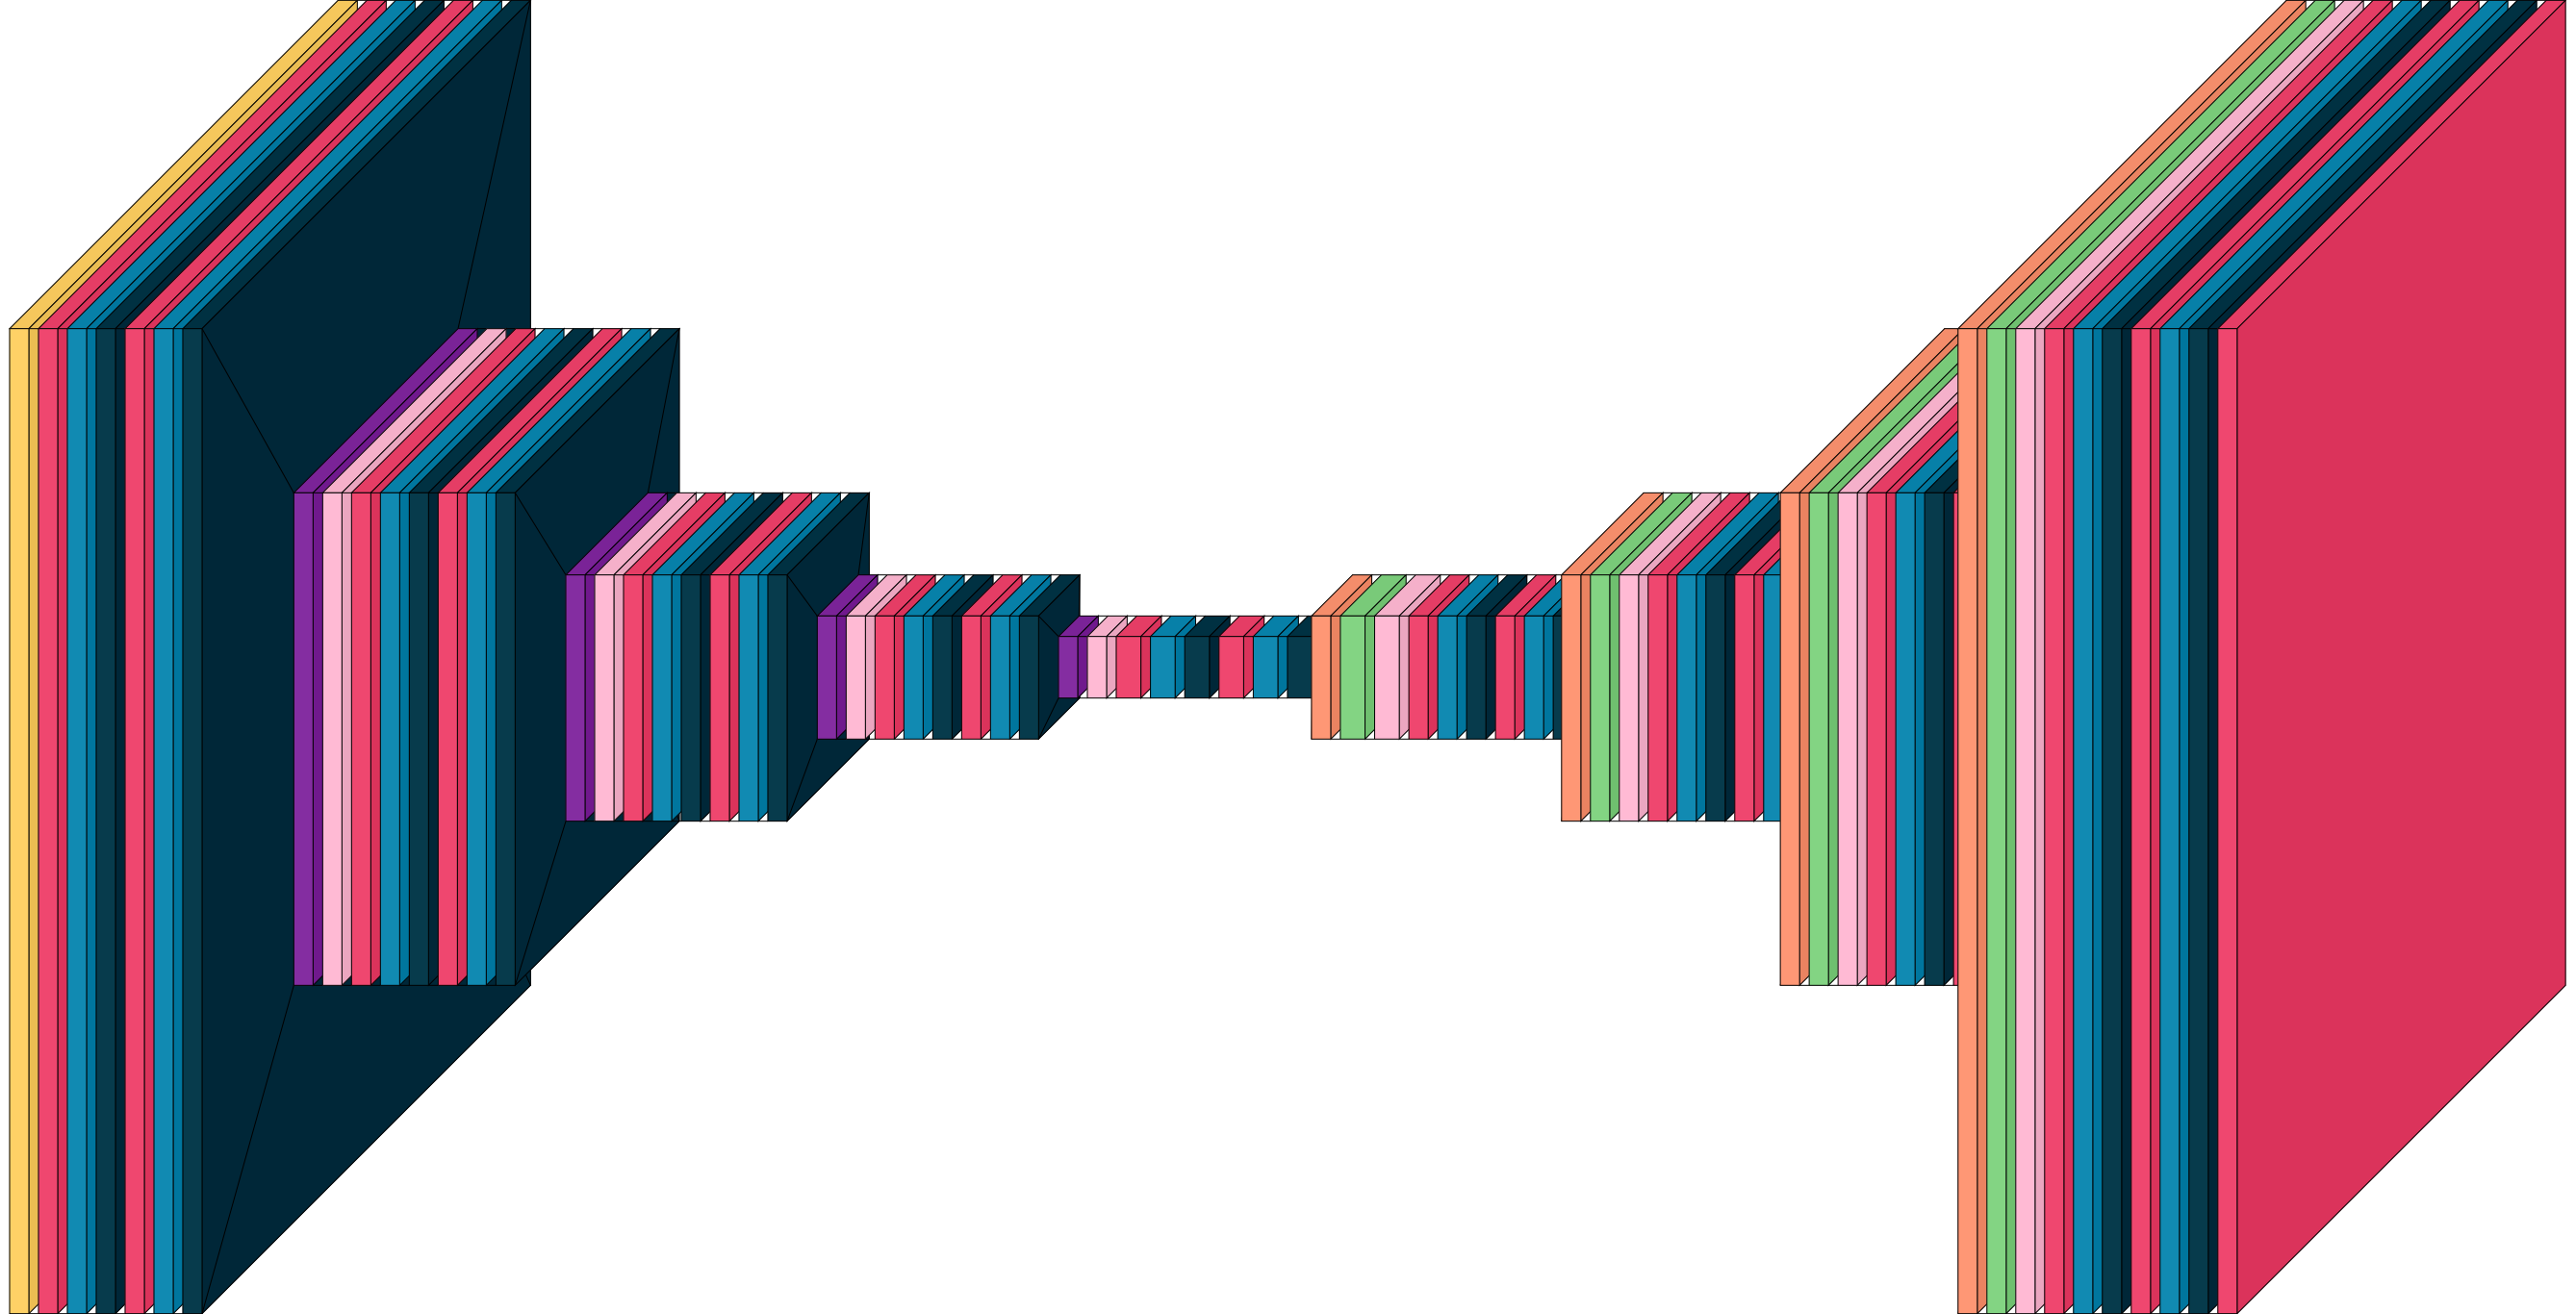

In [24]:
from visualkeras import layered_view
import visualkeras
visualkeras.layered_view(unet_model)

In [26]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('unet_model_best.keras', monitor='val_loss', save_best_only=True, verbose=1)

In [27]:
# Train the model
history = unet_model.fit(X_train,
                         y_train,
                         validation_data=(X_val, y_val),
                         epochs=10,
                         verbose=1,
                         callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8907 - loss: 0.3890   
Epoch 1: val_loss improved from inf to 1.97364, saving model to unet_model_best.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.8917 - loss: 0.3873 - val_accuracy: 0.6461 - val_loss: 1.9736 - learning_rate: 0.0010
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9645 - loss: 0.1887
Epoch 2: val_loss did not improve from 1.97364
47/47 ━━━━━━━━━━━━━━━━━━━━ 50s 316ms/step - accuracy: 0.9645 - loss: 0.1884 - val_accuracy: 0.4347 - val_loss: 3.3673 - learning_rate: 0.0010
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9676 - loss: 0.1420
Epoch 3: val_loss improved from 1.97364 to 0.70220, saving model to unet_model_best.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 353ms/step - accuracy: 0.9676 - loss: 0.1419 - val_accuracy: 0.8046 - val_loss: 0.7022 - learning_rate: 0.0010
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9676 - loss: 0.1231
Epoch 4: 

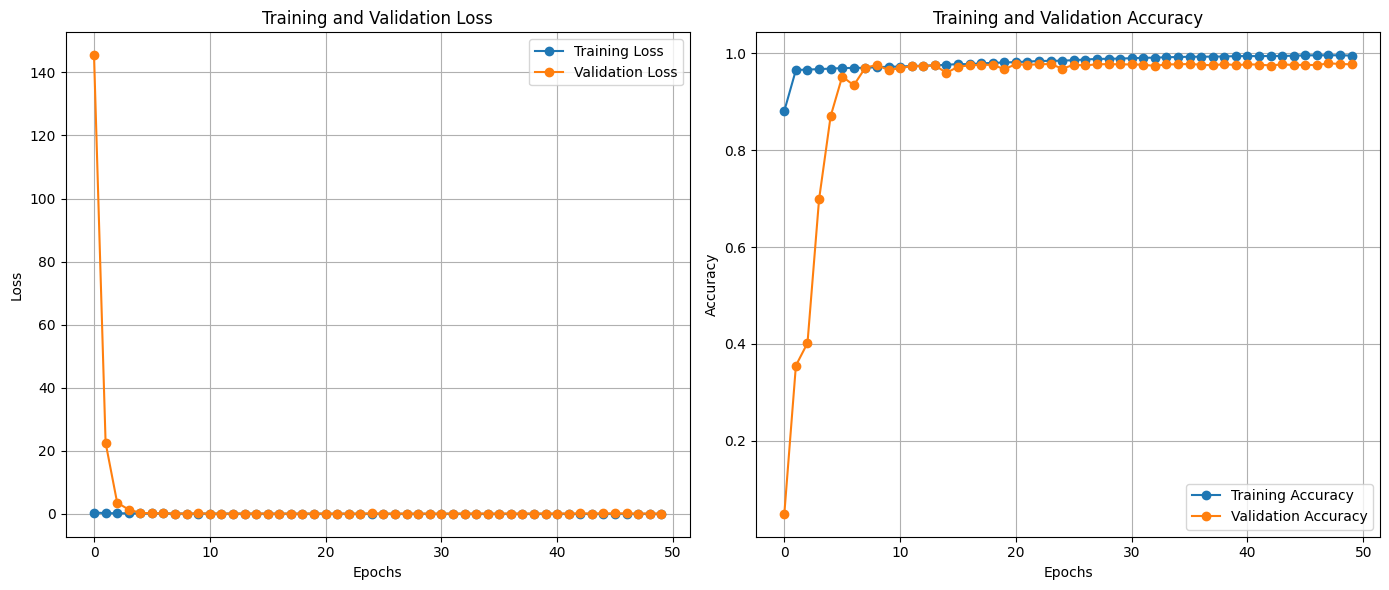

In [61]:
import matplotlib.pyplot as plt

# Plot training and validation loss and accuracy
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()


In [70]:
# Function to predict and time the inference for a single image
def predict_image(image, model):
    start_time = time.time()
    prediction = model.predict(np.expand_dims(image, axis=0))[0, :, :, 0]
    end_time = time.time()
    inference_time = end_time - start_time
    return prediction, inference_time

In [71]:
# Function to visualize the prediction and ground truth
def visualize_segmentation(image, predicted_mask, ground_truth_mask):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title('Ground Truth Mask')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Inference time for a single image: 0.0703 seconds


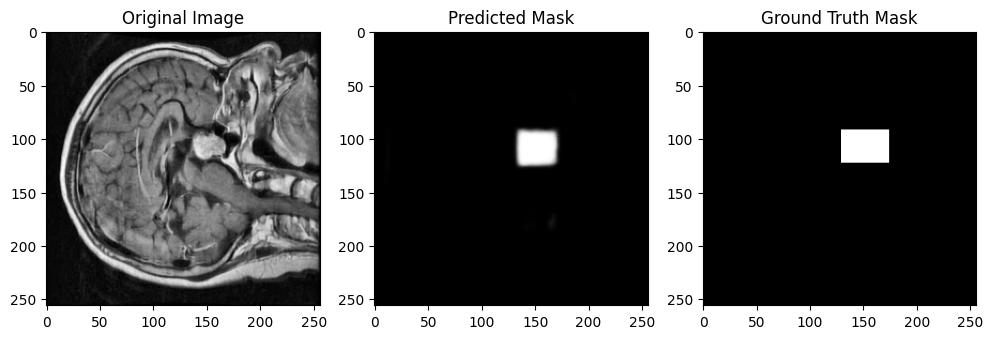

In [72]:
# Example inference on a validation image
sample_image = X_test[0]
sample_ground_truth = y_test[0]

predicted_mask, inference_time = predict_image(sample_image, unet_model)
print(f'Inference time for a single image: {inference_time:.4f} seconds')

# Visualize the result
visualize_segmentation(sample_image, predicted_mask, sample_ground_truth)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Inference time for a single image: 0.0789 seconds


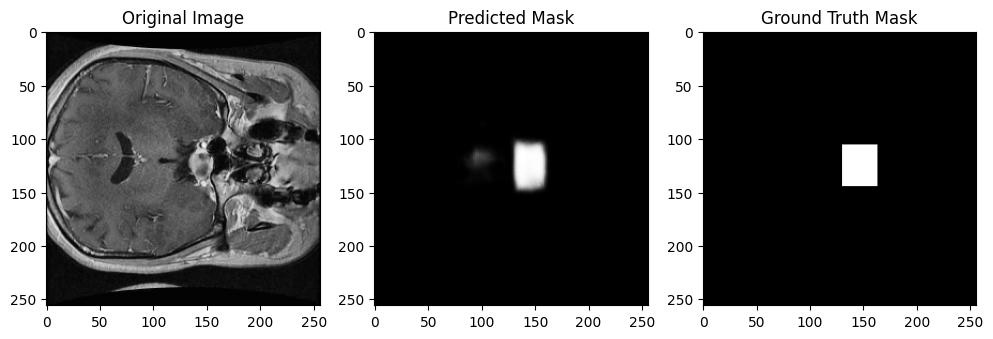

In [74]:
# Example inference on a validation image
sample_image = X_test[10]
sample_ground_truth = y_test[10]

predicted_mask, inference_time = predict_image(sample_image, unet_model)
print(f'Inference time for a single image: {inference_time:.4f} seconds')

# Visualize the result
visualize_segmentation(sample_image, predicted_mask, sample_ground_truth)

## Adding IOU to the metrics while training Model

In [35]:
EPOCHS = 50

In [36]:
import tensorflow.keras.backend as K
def mean_iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [37]:
# Get IOU for Training Data
y_pred = unet_model.predict(X_train)
print(mean_iou(y_train,y_pred))

47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step
tf.Tensor(0.23985519, shape=(), dtype=float32)


In [38]:
# Get IOU for Test Data
y_pred = unet_model.predict(X_test)
print(mean_iou(y_test,y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
tf.Tensor(0.2546966, shape=(), dtype=float32)


In [39]:
# Get IOU for Validation Data
y_pred = unet_model.predict(X_val)
print(mean_iou(y_val,y_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step
tf.Tensor(0.25034472, shape=(), dtype=float32)


In [40]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def mean_iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [41]:
input_shape = (256, 256, 3)
unet_model = build_unet(input_shape, dropout_rate=0.07)

In [42]:
# Compile the U-Net model with Dice coefficient and mean IoU as metrics
unet_model.compile(optimizer='Adam', loss='binary_crossentropy',
                   metrics=['accuracy', dice_coefficient, mean_iou])

In [43]:
# Train the model with the additional metrics
history = unet_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, verbose=1)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 68s 802ms/step - accuracy: 0.7689 - dice_coefficient: 0.0802 - loss: 0.5315 - mean_iou: 0.0418 - val_accuracy: 0.0496 - val_dice_coefficient: 0.0734 - val_loss: 145.4473 - val_mean_iou: 0.0381
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 325ms/step - accuracy: 0.9655 - dice_coefficient: 0.1058 - loss: 0.2399 - mean_iou: 0.0559 - val_accuracy: 0.3555 - val_dice_coefficient: 0.0966 - val_loss: 22.5528 - val_mean_iou: 0.0508
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 332ms/step - accuracy: 0.9670 - dice_coefficient: 0.1428 - loss: 0.1899 - mean_iou: 0.0769 - val_accuracy: 0.4018 - val_dice_coefficient: 0.1074 - val_loss: 3.5292 - val_mean_iou: 0.0568
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 337ms/step - accuracy: 0.9664 - dice_coefficient: 0.1738 - loss: 0.1604 - mean_iou: 0.0953 - val_accuracy: 0.6983 - val_dice_coefficient: 0.1399 - val_loss: 1.3478 - val_mean_iou: 0.0753
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 329ms/step - accuracy: 0.9676 - dice_co

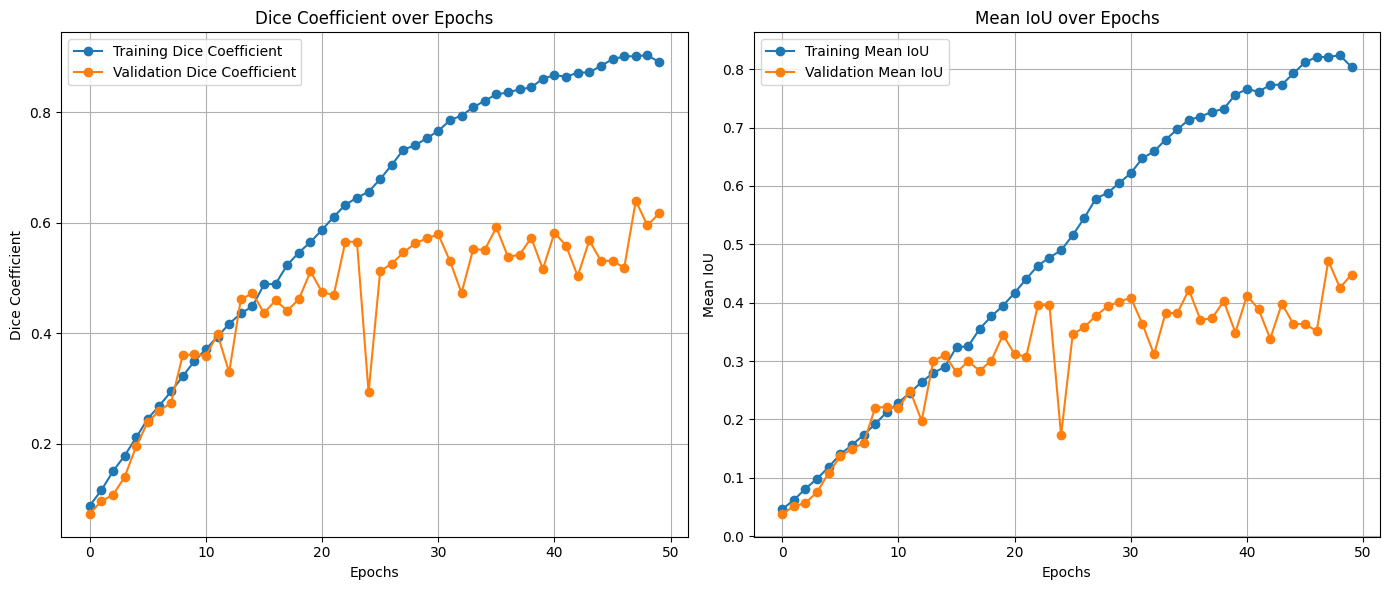

In [60]:
import matplotlib.pyplot as plt

# Plot Dice coefficient and mean IoU during training and validation
plt.figure(figsize=(14, 6))

# Plot Dice Coefficient
plt.subplot(1, 2, 1)
plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient', marker='o')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid(True)
plt.title('Dice Coefficient over Epochs')

# Plot Mean IoU
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_iou'], label='Training Mean IoU', marker='o')
plt.plot(history.history['val_mean_iou'], label='Validation Mean IoU', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.grid(True)
plt.title('Mean IoU over Epochs')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


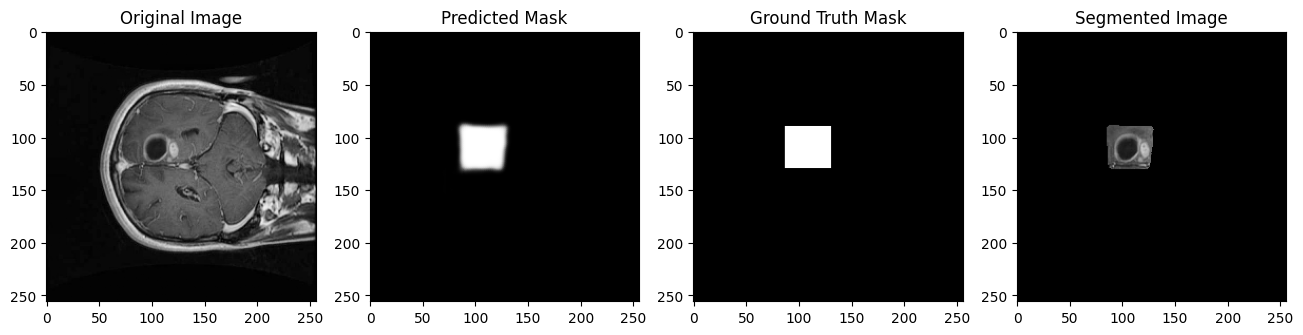

In [75]:
def visualize_segmentation_part(image, predicted_mask, ground_truth_mask):
    # Threshold the predicted mask to create a binary mask for segmentation
    binary_mask = (predicted_mask > 0.5).astype(np.uint8)

    # Plotting the original image, predicted mask, ground truth mask, and segmented image
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.subplot(1, 4, 3)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title('Ground Truth Mask')

    # Apply the binary mask to the original image to create the segmented output
    segmented_image = cv2.merge((binary_mask, binary_mask, binary_mask)) * image

    plt.subplot(1, 4, 4)
    plt.imshow(segmented_image)
    plt.title('Segmented Image')

    plt.show()

# Example usage
sample_image = X_train[10]
sample_ground_truth = y_train[10]

predicted_mask, _ = predict_image(sample_image, unet_model)

# Visualize the segmentation results with cropping
visualize_segmentation_part(sample_image, predicted_mask, sample_ground_truth)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


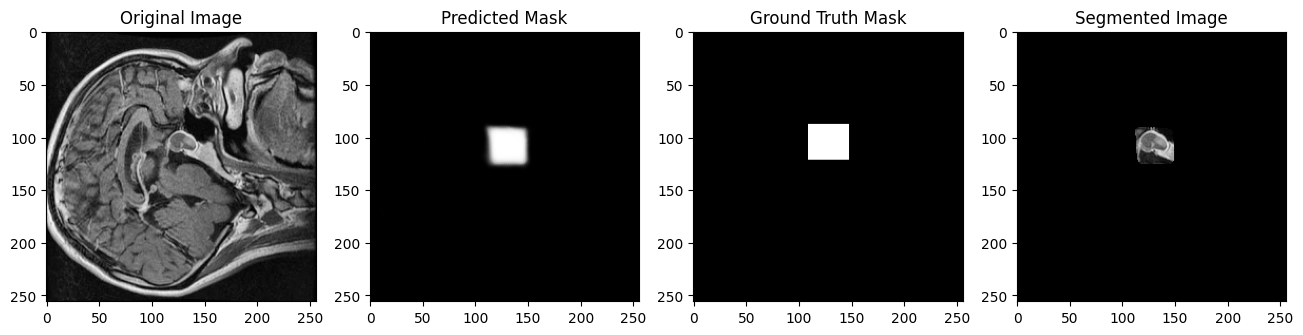

In [76]:
# Example usage
sample_image = X_test[21]
sample_ground_truth = y_test[21]

predicted_mask, _ = predict_single_image(sample_image, unet_model)

# Visualize the segmentation results with cropping
visualize_segmentation_with_cropping(sample_image, predicted_mask, sample_ground_truth)


In [56]:
unet_model.save('final_UNET_Brain_Tumor.keras')